# Handling3dTraces : a numpy container of 3D traces


Handling3dTraces performs specific processing for 3D traces and plotting, available in module 
* `grand/basis/traces_event.py`

It is completely independent of the GRANDROOT format. Handling3dTraces can be initialize with GRANDROOT event file with function:
* `get_handling3dtraces(f_name, idx_evt=0)` in module `grand/dataio/root_file.py`

## Features

### Processing:

* Compute time for sample of each trace : attribut `t_sample`
* Apply bandpass filter in place, causal or not : `apply_bandpass()`
* Estimate power spectrum density (PSD) with Welch method from scipy : `function get_psd()`
* Downsampling traces with scipy function decimate : `downsize_sampling()`
* Compute different kind of maximun value and time associated : `get_tmax_vmax()`
   * max absolute value
   * max norm 
   * max norm of Hilbert transform
* Maximum value and time max can be interpoleted with 2 modes : `get_tmax_vmax()`
   * pic: fit parabola with 3 points
   * hill : fit parabola on set of points with least square method
* Compute an estimation of sigma noise and SNR : `get_snr_and_noise()`

### 3D trace/DU handling

* Copy an object Handling3dTraces : `copy()`
* Remove/Select trace with identifier or index : `remove_trace_low_signal()`
* Remove/Select trace with crieteria provided by user like : SNR, personnal norm , ...

### Plot/figure

* Plot 3D traces by index or identifier : `plot_trace_idx()`
* Plot density power spectrum of 3D traces by index or identifier : `plot_psd_idx()`
* Footprint of max value and time of max : `plot_footprint_val_max()`
* Footprint 4D, ie 4 plots: time of max and max value of each axis : `plot_footprint_4d_max()`
* Footprint of max value with a time slider : `plot_footprint_time_slider()`
* Footprint of "generic value", like residu by DU : `network.plot_footprint_1d()`


## Example : fake noisy pulse

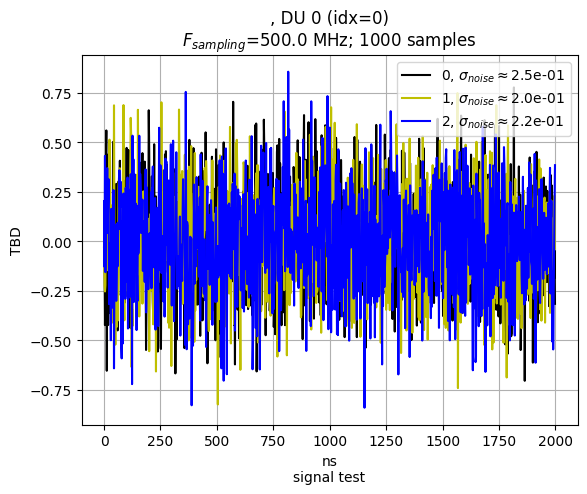

In [103]:
from grand.basis.traces_event import Handling3dTraces 
import numpy as np

np.random.seed(57)

a_noise = np.random.normal(0,0.25,5*3*1000).reshape((5,3,1000))
tr3d = Handling3dTraces("signal test")
tr3d.init_traces(a_noise, f_samp_mhz=500)
tr3d.plot_trace_idx(0)

You can add some informations like unit, type of trace and name axis with method `set_unit_axis()`

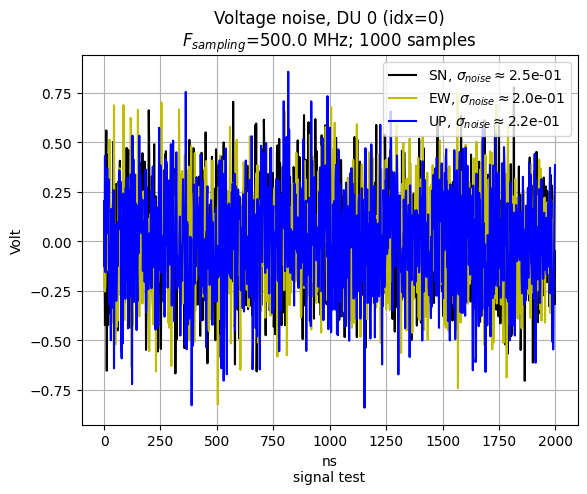

In [104]:
tr3d.set_unit_axis(str_unit="Volt", axis_name="dir", type_tr="Voltage noise")
tr3d.plot_trace_idx(0)

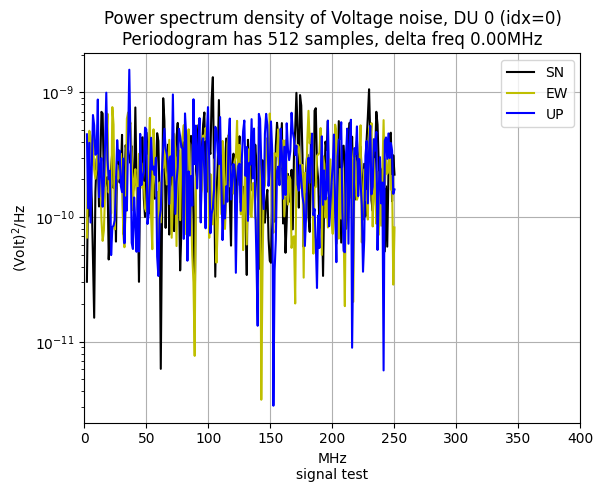

In [105]:
tr3d.plot_psd_trace_idx(0)

The size of periodogram is configurable, to obtain a smooth PSD with Welch method reduce size of periodogram 512 to 64 samples

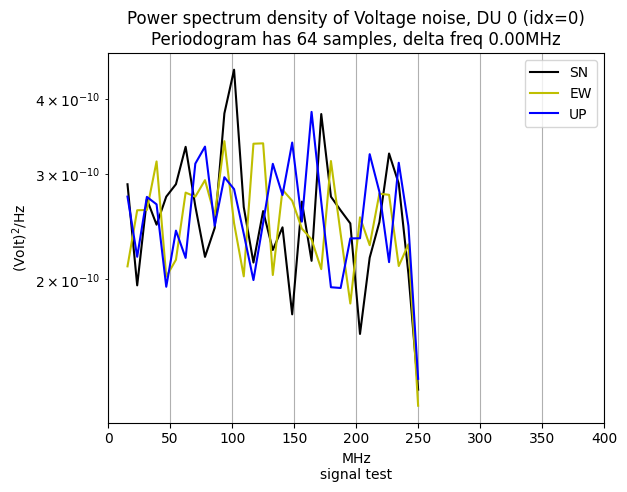

In [106]:
tr3d.set_periodogram(64)
tr3d.plot_psd_trace_idx(0)

Add signal like a big pulse

In [107]:
x_max = 80
v_x, step = np.linspace(-x_max, x_max, 1000, retstep=True)


In [108]:
import scipy as scp
blackman = scp.signal.windows.blackman(1000)
v_y = np.sin(v_x) * blackman

In [109]:
tr3d.traces[:,0] += 4*v_y
tr3d.traces[:,1] += 3*v_y
tr3d.traces[:,2] += 0

The maximum value is $\sqrt{4^2+3^2+0^2}=5$

and the true time  of max is 

In [110]:
time_max = (x_max / step) * tr3d.get_delta_t_ns()[0]
print(f'True time max: {time_max} ns')

True time max: 999.0 ns


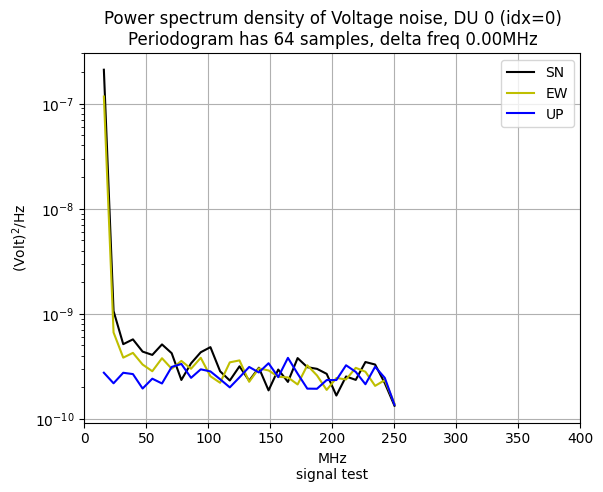

In [111]:
tr3d.plot_psd_trace_idx(0)

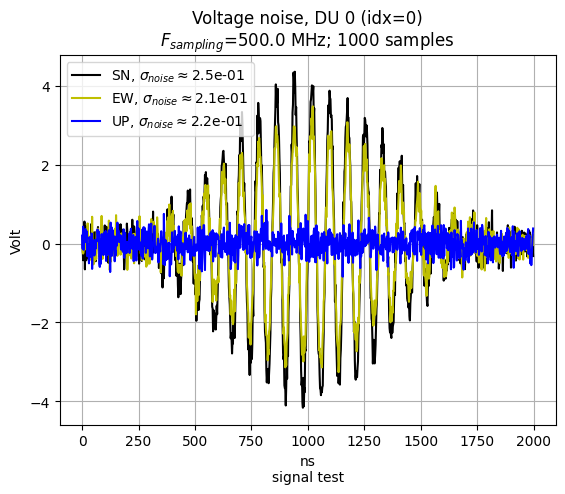

In [112]:
tr3d.plot_trace_idx(0)

### Find the maximum value

To add maximum value in plot call `get_tmax_vmax()`method

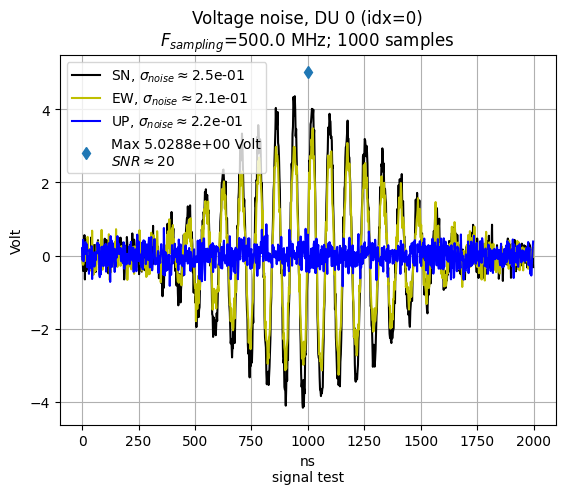

In [113]:
t_max, v_max = tr3d.get_tmax_vmax(hilbert=True, interpol="auto")
tr3d.plot_trace_idx(0)

In [114]:
print(f'time max estimated: {t_max[0]:.2f} ns')

time max estimated: 998.87 ns


and max value estimated is 5.03 (see legend of the plot).

Not too bad, now estimate maximum value wihtout Hilbert transform and interpolation

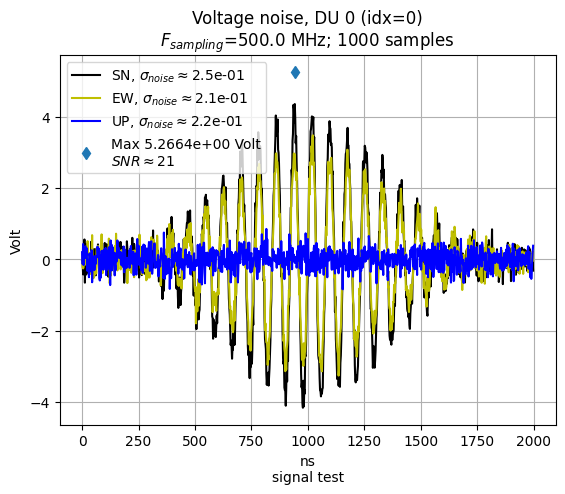

In [115]:
t_max, v_max = tr3d.get_tmax_vmax(hilbert=False, interpol="no")
tr3d.plot_trace_idx(0)

In [116]:
print(f'time max estimated: {t_max[0]:.2f} ns')

time max estimated: 942.00 ns


Estimation go to the "noisy" maximum

### Downsampling

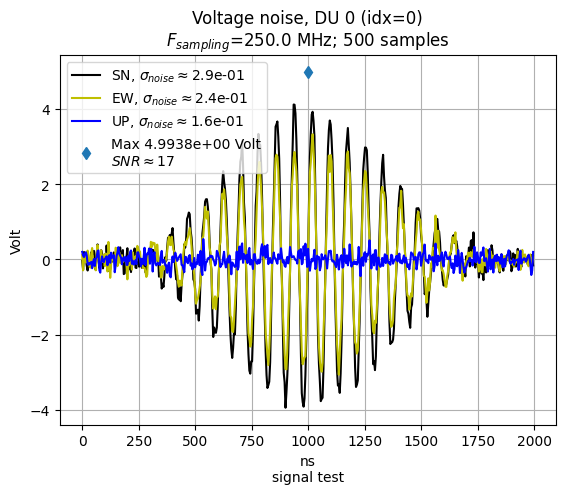

In [117]:
tr3d.downsize_sampling(2)
t_max, v_max = tr3d.get_tmax_vmax(hilbert=True, interpol="auto")
tr3d.plot_trace_idx(0)

In [118]:
print(f'time max estimated: {t_max[0]:.2f} ns')

time max estimated: 997.54 ns


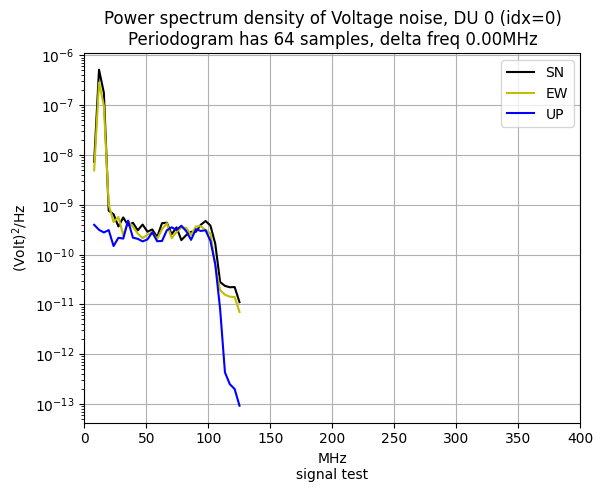

In [119]:
tr3d.plot_psd_trace_idx(0)

You can see effect of low pass filter apply by scipy function `decimate()` call by method `downsize_sampling()`

## With GRANDROOT file

Initialize numpy container with a unique function `get_handling3dtraces(idx_trace)`

In [120]:
from grand.dataio.root_files import get_handling3dtraces

In [121]:
f_root  = "../../sim2root/Common/sim_Xiaodushan_20221026_180000_RUN0_CD_DC2Alpha_0000/efield_0-1_L0_0000.root"
ef3d = get_handling3dtraces(f_root)

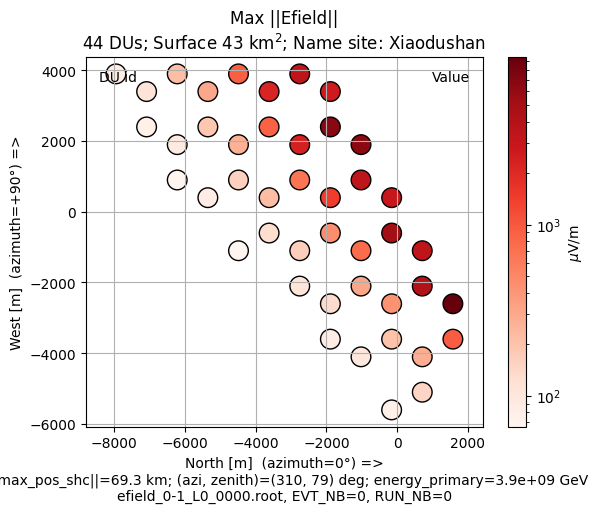

In [122]:
ef3d.plot_footprint_val_max()


As you see on plot, some information from Tshower/Trun file are set, like:
* Unit  
* Xmax distance
* primary energy
* direction of Xmax 
* Name site
* Surface of the network is computed.

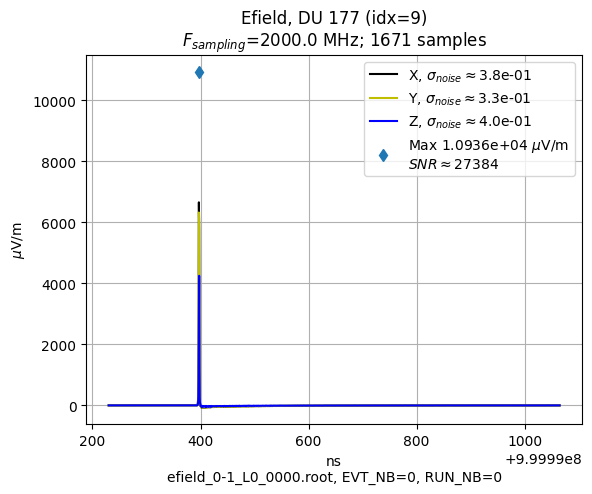

In [123]:
ef3d.get_tmax_vmax()
ef3d.plot_trace_idx(9)

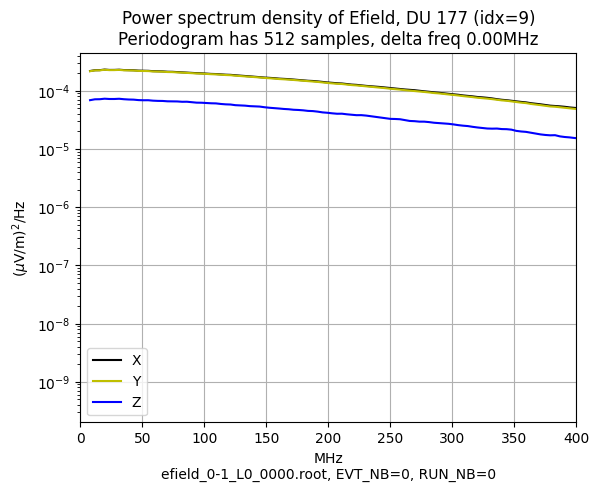

In [124]:
ef3d.plot_psd_trace_idx(9)

### Apply bandpass filter 

The frequency band is GRAND antenna ~ 80 MHz to 230 MHz

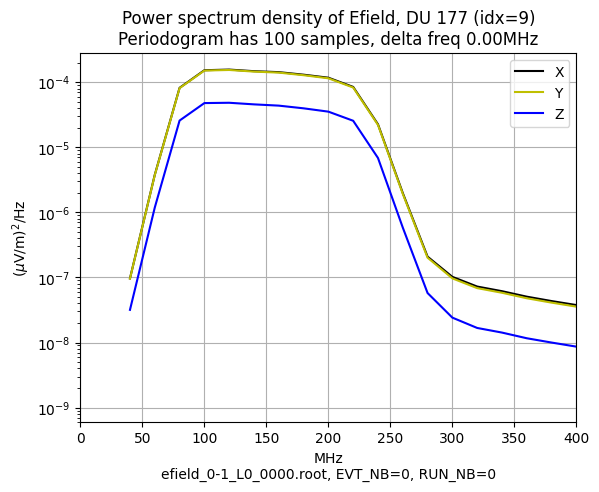

In [125]:
ef3d.apply_bandpass(80,230)
ef3d.set_periodogram(100)
ef3d.plot_psd_trace_idx(9)

By default the filter is causal.

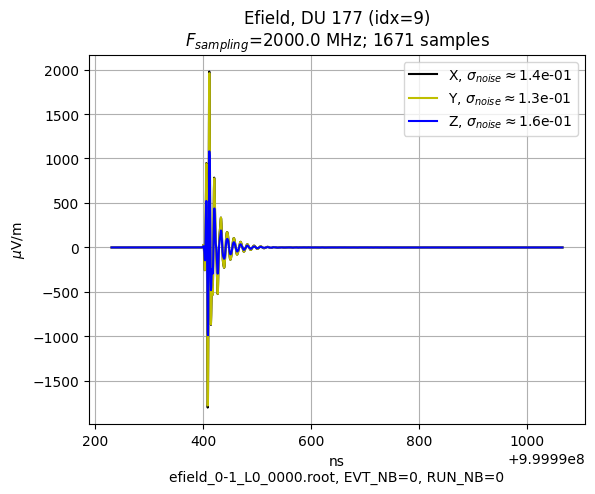

In [126]:
ef3d.plot_trace_idx(9)

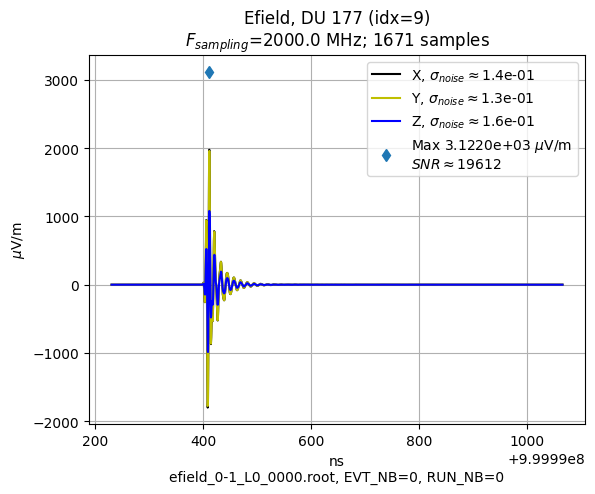

In [127]:
ef3d.get_tmax_vmax()
ef3d.plot_trace_idx(9)

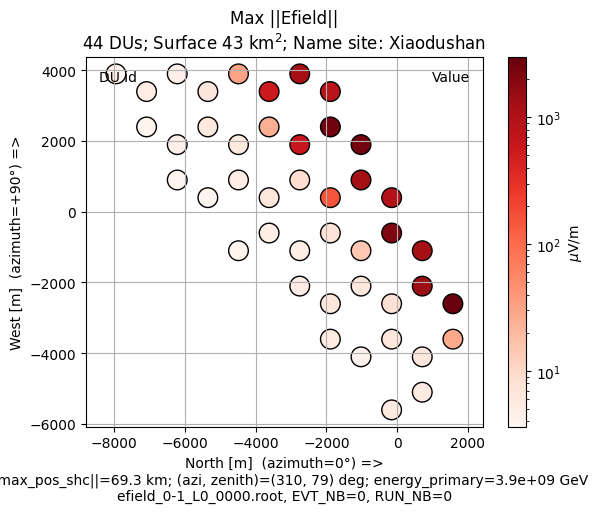

In [128]:
ef3d.plot_footprint_val_max()

### Remove DU with low signal

In [129]:
l_idx_ok = ef3d.remove_trace_low_signal(75)

Index of DU selected

In [130]:
l_idx_ok

array([ 9, 12, 16, 19, 22, 23, 27, 30, 31, 35, 38, 39, 43])

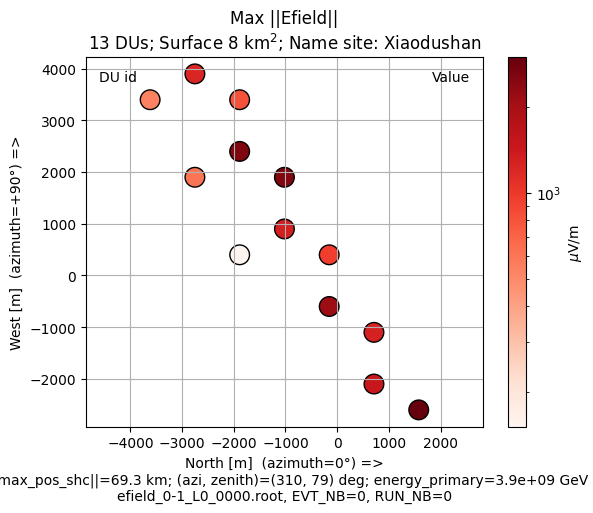

In [131]:
ef3d.plot_footprint_val_max()

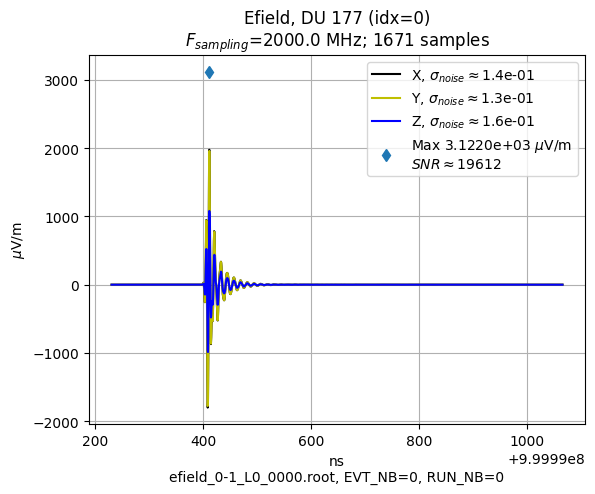

In [132]:
ef3d.get_tmax_vmax()
ef3d.plot_trace_du(177)

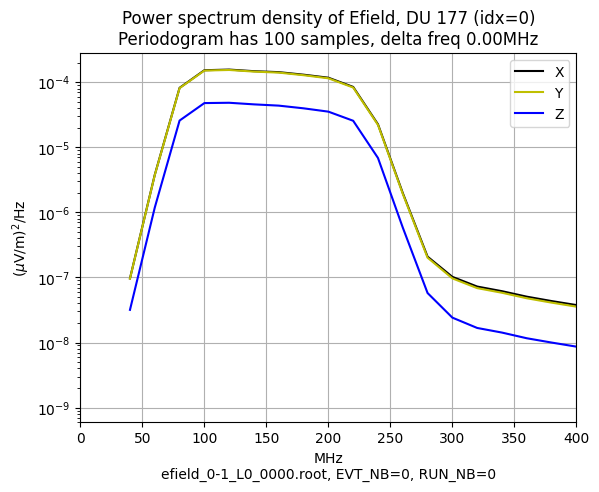

In [133]:
ef3d.plot_psd_trace_du(177)

## Copy and generic footprint plot

We will compare the time shifting of time maximum value for full frequency EField and EField see by GRAND bandpass 

In [134]:
ef3d_full = get_handling3dtraces("../../sim2root/Common/sim_Xiaodushan_20221026_180000_RUN0_CD_DC2Alpha_0000/efield_0-1_L0_0000.root")
ef3d_grand = ef3d_full.copy()
ef3d_grand.type_trace += "*GRAND bandpass" 
ef3d_grand.apply_bandpass(80,250)


In [135]:
t_max_full, _ = ef3d_full.get_tmax_vmax()
t_max_grand, _ = ef3d_grand.get_tmax_vmax()

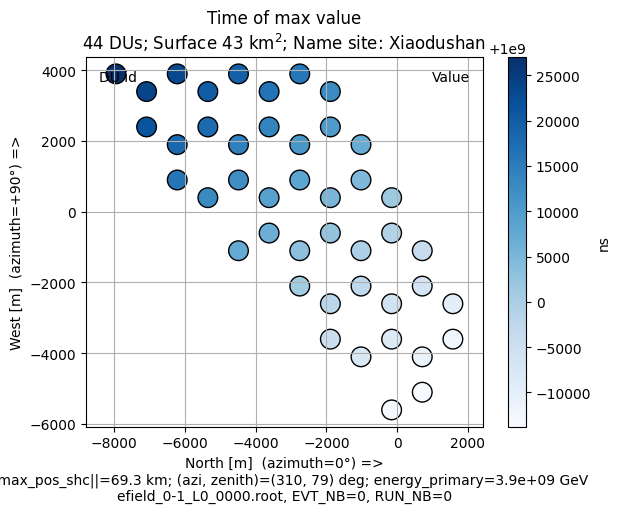

In [136]:
ef3d_grand.plot_footprint_time_max()

Note the title of the plot

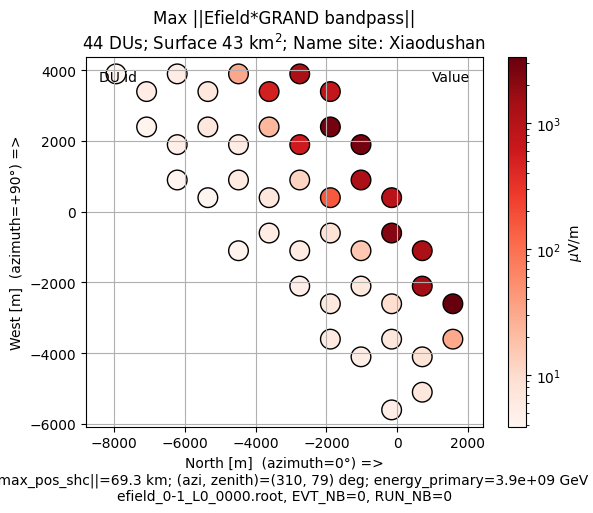

In [137]:
ef3d_grand.plot_footprint_val_max()

The 2 set of traces shares the same network

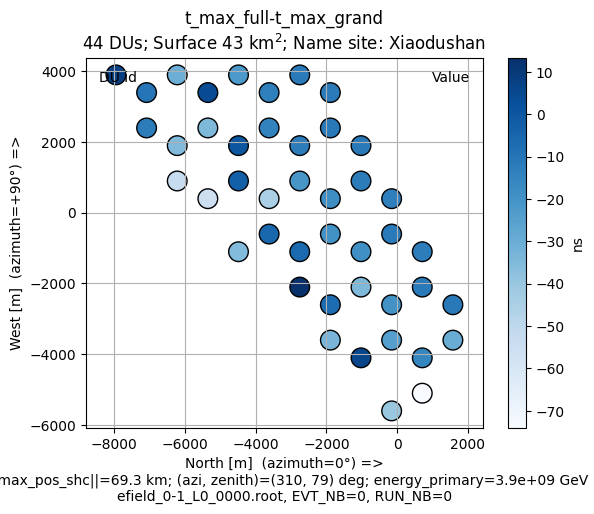

In [138]:
ef3d_full.network.plot_footprint_1d(t_max_full-t_max_grand,"t_max_full-t_max_grand", ef3d_full, scale="lin", unit="ns")

Remove low signal for GRAND traces and apply same selection for full frequency traces

In [139]:
l_idx_ok = ef3d_grand.remove_trace_low_signal(75)
ef3d_full.keep_only_trace_with_index(l_idx_ok)

In [140]:
ef3d_full.idx2idt

[177, 207, 229, 237, 244, 245, 252, 258, 259, 265, 270, 271, 276]

In [141]:
ef3d_grand.idx2idt

[177, 207, 229, 237, 244, 245, 252, 258, 259, 265, 270, 271, 276]

In [142]:
ef3d_full.idx2idt == ef3d_grand.idx2idt

True

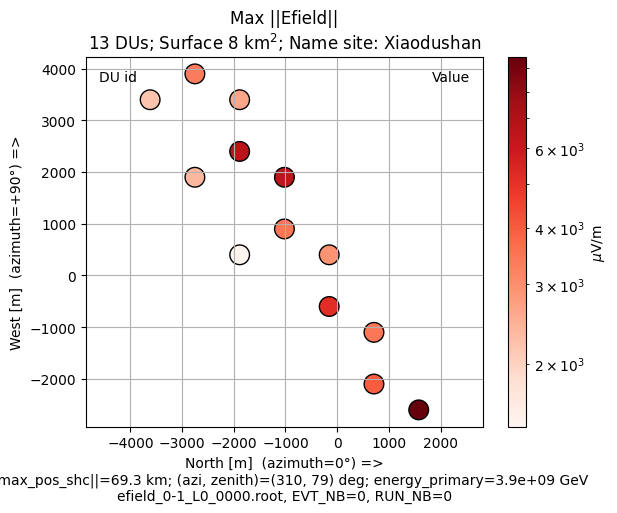

In [143]:
ef3d_full.plot_footprint_val_max()

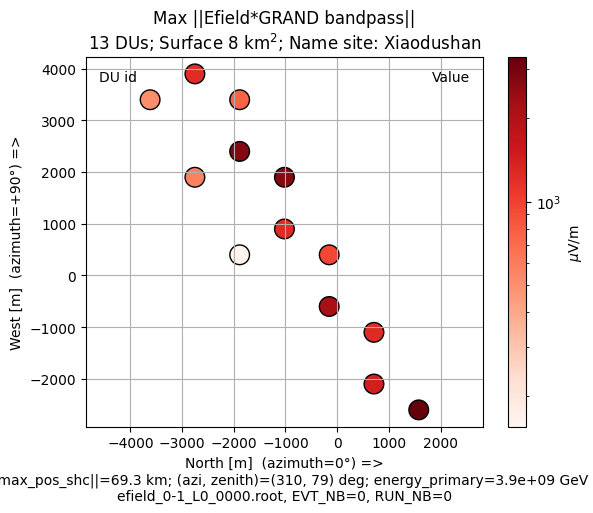

In [144]:
ef3d_grand.plot_footprint_val_max()

We must recompute t_max

In [145]:
t_max_full, _ = ef3d_full.get_tmax_vmax()
t_max_grand, _ = ef3d_grand.get_tmax_vmax()

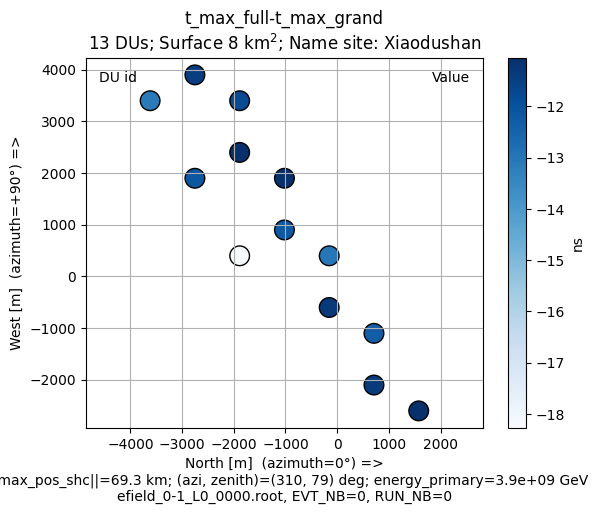

In [146]:
ef3d_full.network.plot_footprint_1d(t_max_full-t_max_grand,"t_max_full-t_max_grand", ef3d_full, scale="lin", unit="ns")

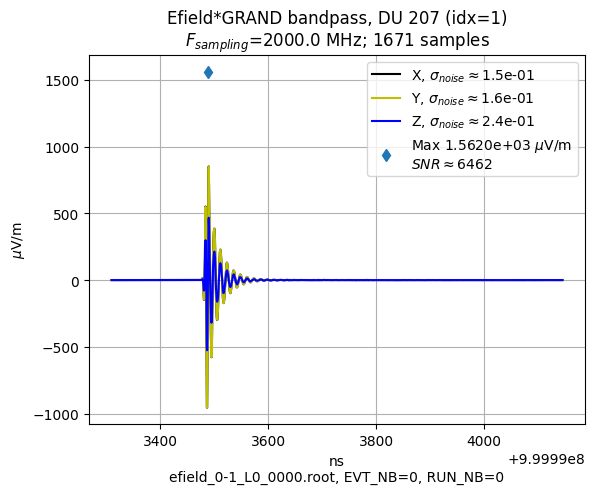

In [147]:
ef3d_grand.plot_trace_idx(1)

Now no causal filter bandpass

In [148]:
ef3d_grand_no_causal= get_handling3dtraces(f_root)

In [149]:
ef3d_grand_no_causal.apply_bandpass(80,250,causal=False)
ef3d_grand_no_causal.keep_only_trace_with_index(l_idx_ok)

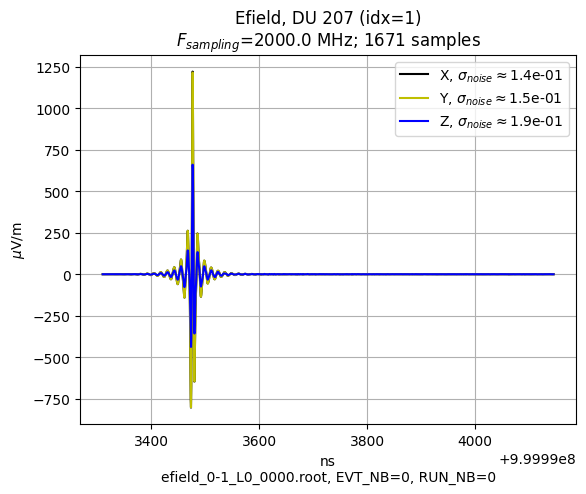

In [150]:
ef3d_grand_no_causal.plot_trace_idx(1)

In [151]:
t_max_grand_nc, _ = ef3d_grand_no_causal.get_tmax_vmax()

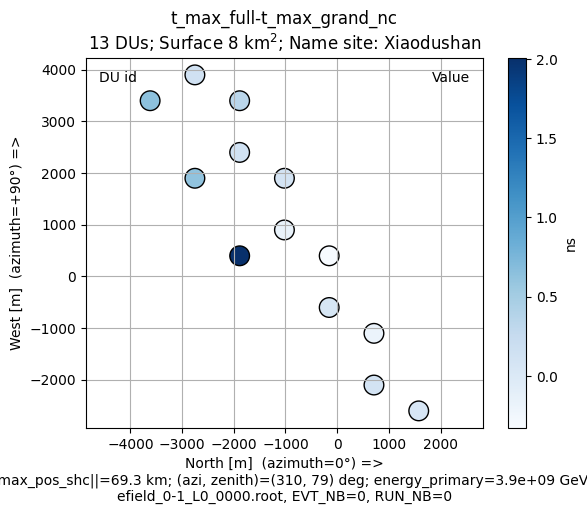

In [152]:
ef3d_full.network.plot_footprint_1d(t_max_full-t_max_grand_nc,"t_max_full-t_max_grand_nc", ef3d_full, scale="lin", unit="ns")